# Simple Volatility Trading Strategy

Notebook implements a very simple volatility trading strategy found in Ahmad & Wilmott (2005).

- Strategy: RV(t+1) - VIX(t) > 0 --> BUY VXX. Vice versa.
    - Expect RV(t+1) to be better predictor of VIX(t+1) than VIX(t)
- RV(t+1) is the GARCH or NoVaS predicted realized volatility for next period
- IV(t) = VIX(t) is the current implied volatility

In [42]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kurtosis
from novas import *
from arch import arch_model
from garch import garch_forecast, arch_p

In [43]:
# data read in, adjustment and conversion to returns
sp500_data = pd.read_csv("./data/sp500index.csv")
sp500_data.index = sp500_data["Date"].astype('datetime64[ns]')
sp500_data.drop(columns=['Date'],inplace=True)

# convert to returns and normalize returns
sp500_returns = sp500_data['Close'].pct_change()[1:]
sp500_returns = (sp500_returns - np.mean(sp500_returns))/np.std(sp500_returns) # normalize to have mean 0 std 1

In [44]:
vix = pd.read_csv("./data/VIXindex.csv", index_col= ['Date'])
vix.index = vix.index.astype('datetime64[ns]')
vix.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,17.240000,17.240000,17.240000,17.240000,17.240000,0
1990-01-03,18.190001,18.190001,18.190001,18.190001,18.190001,0
1990-01-04,19.219999,19.219999,19.219999,19.219999,19.219999,0
1990-01-05,20.110001,20.110001,20.110001,20.110001,20.110001,0
1990-01-08,20.260000,20.260000,20.260000,20.260000,20.260000,0


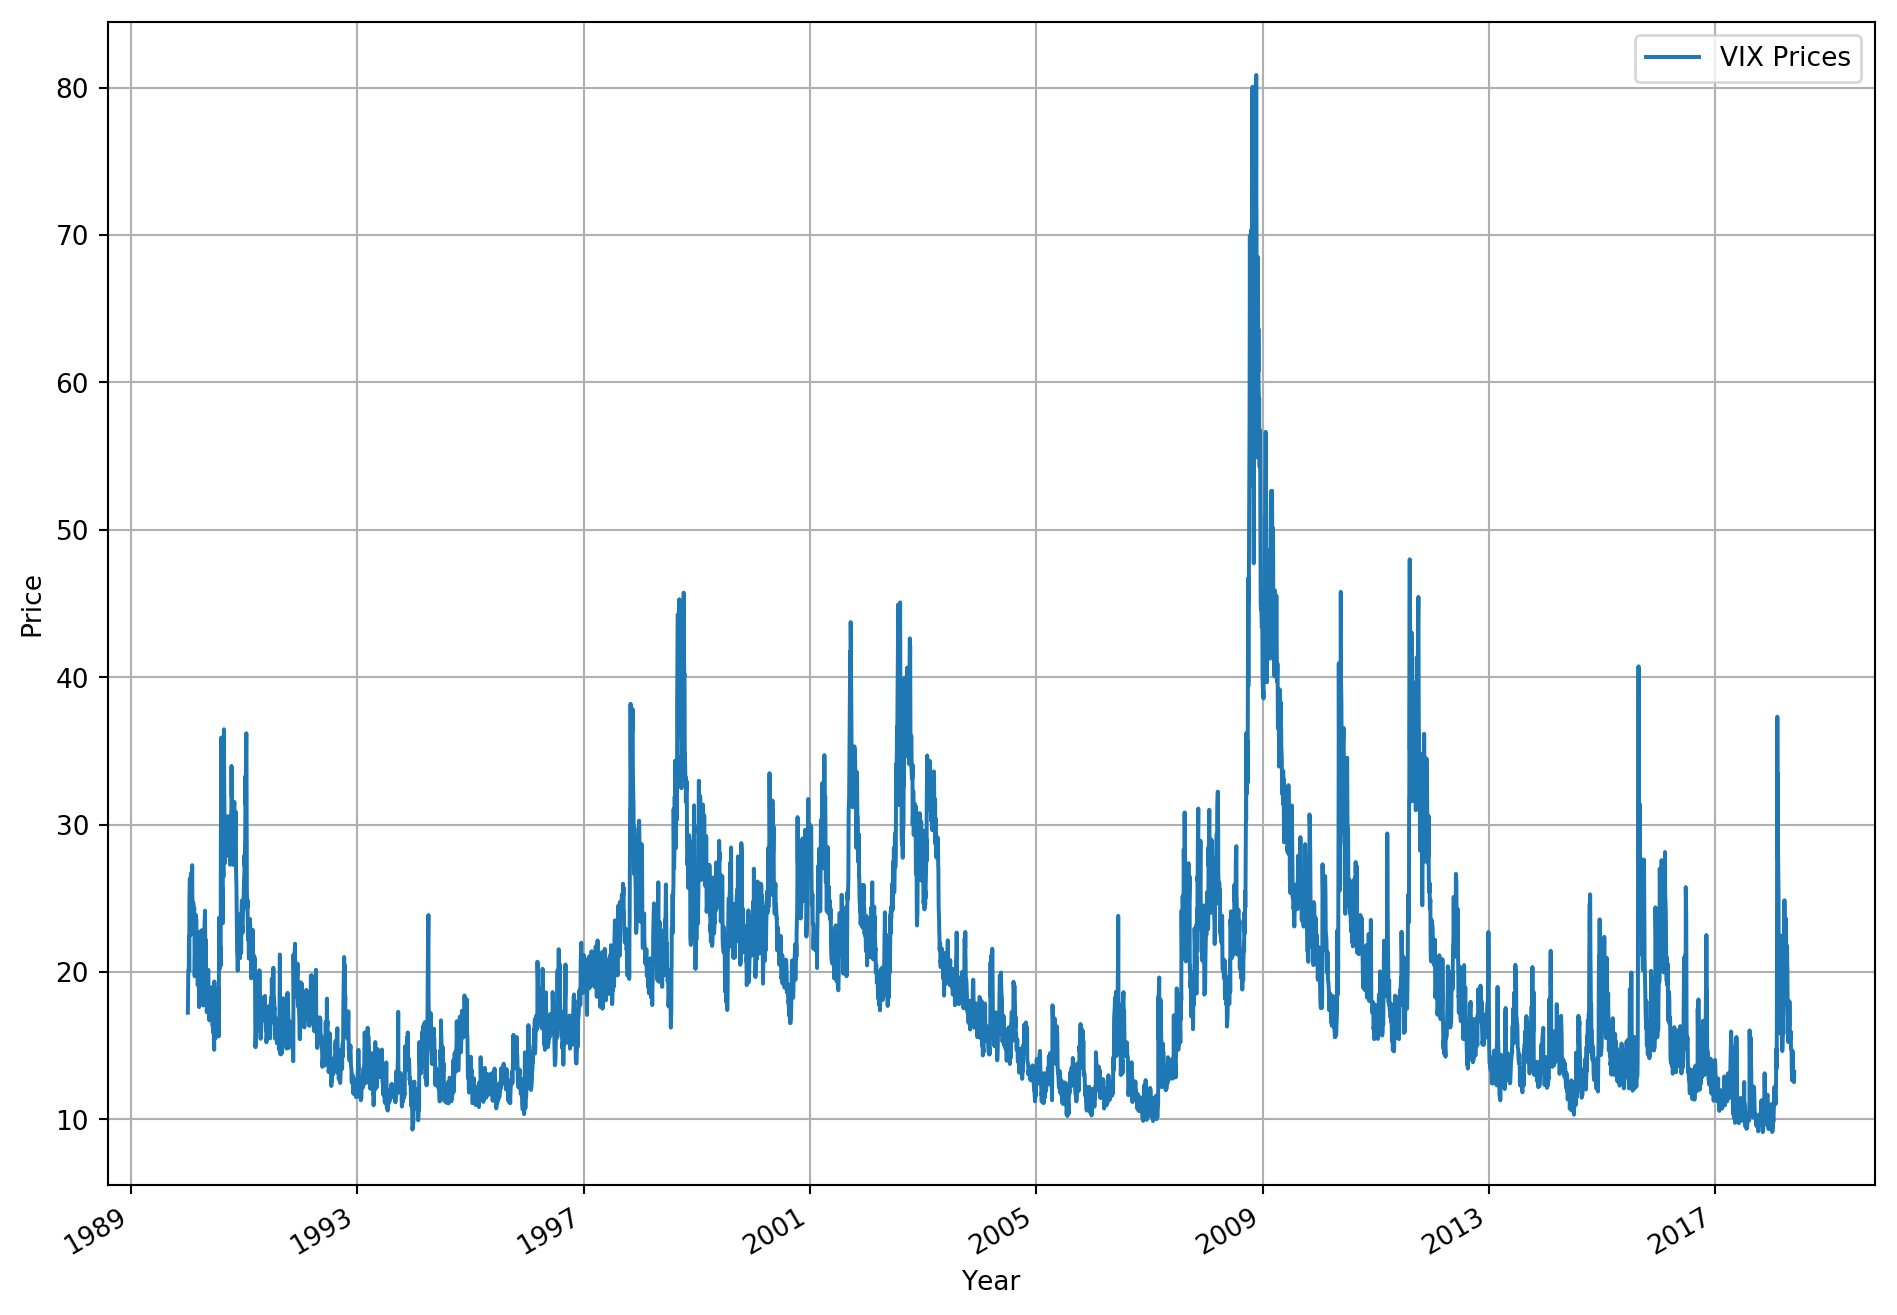

In [48]:
plt.figure(figsize=(12, 9), dpi=190)
vix['Close'].plot()
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend(['VIX Prices']);

In [46]:
vxx = pd.read_csv("./data/VXX.csv", index_col= ['Date'])
vxx.index = vxx.index.astype('datetime64[ns]')
vxx.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-30,102512.640625,107560.960938,102144.000000,107089.921875,107089.921875,200
2009-02-02,110694.398438,110694.398438,106434.562500,106752.000000,106752.000000,300
2009-02-03,106639.359375,106639.359375,101693.437500,101754.882813,101754.882813,100
2009-02-04,100608.000000,102799.359375,99328.000000,102133.757813,102133.757813,100
2009-02-05,104038.398438,106280.960938,100505.601563,101509.117188,101509.117188,200


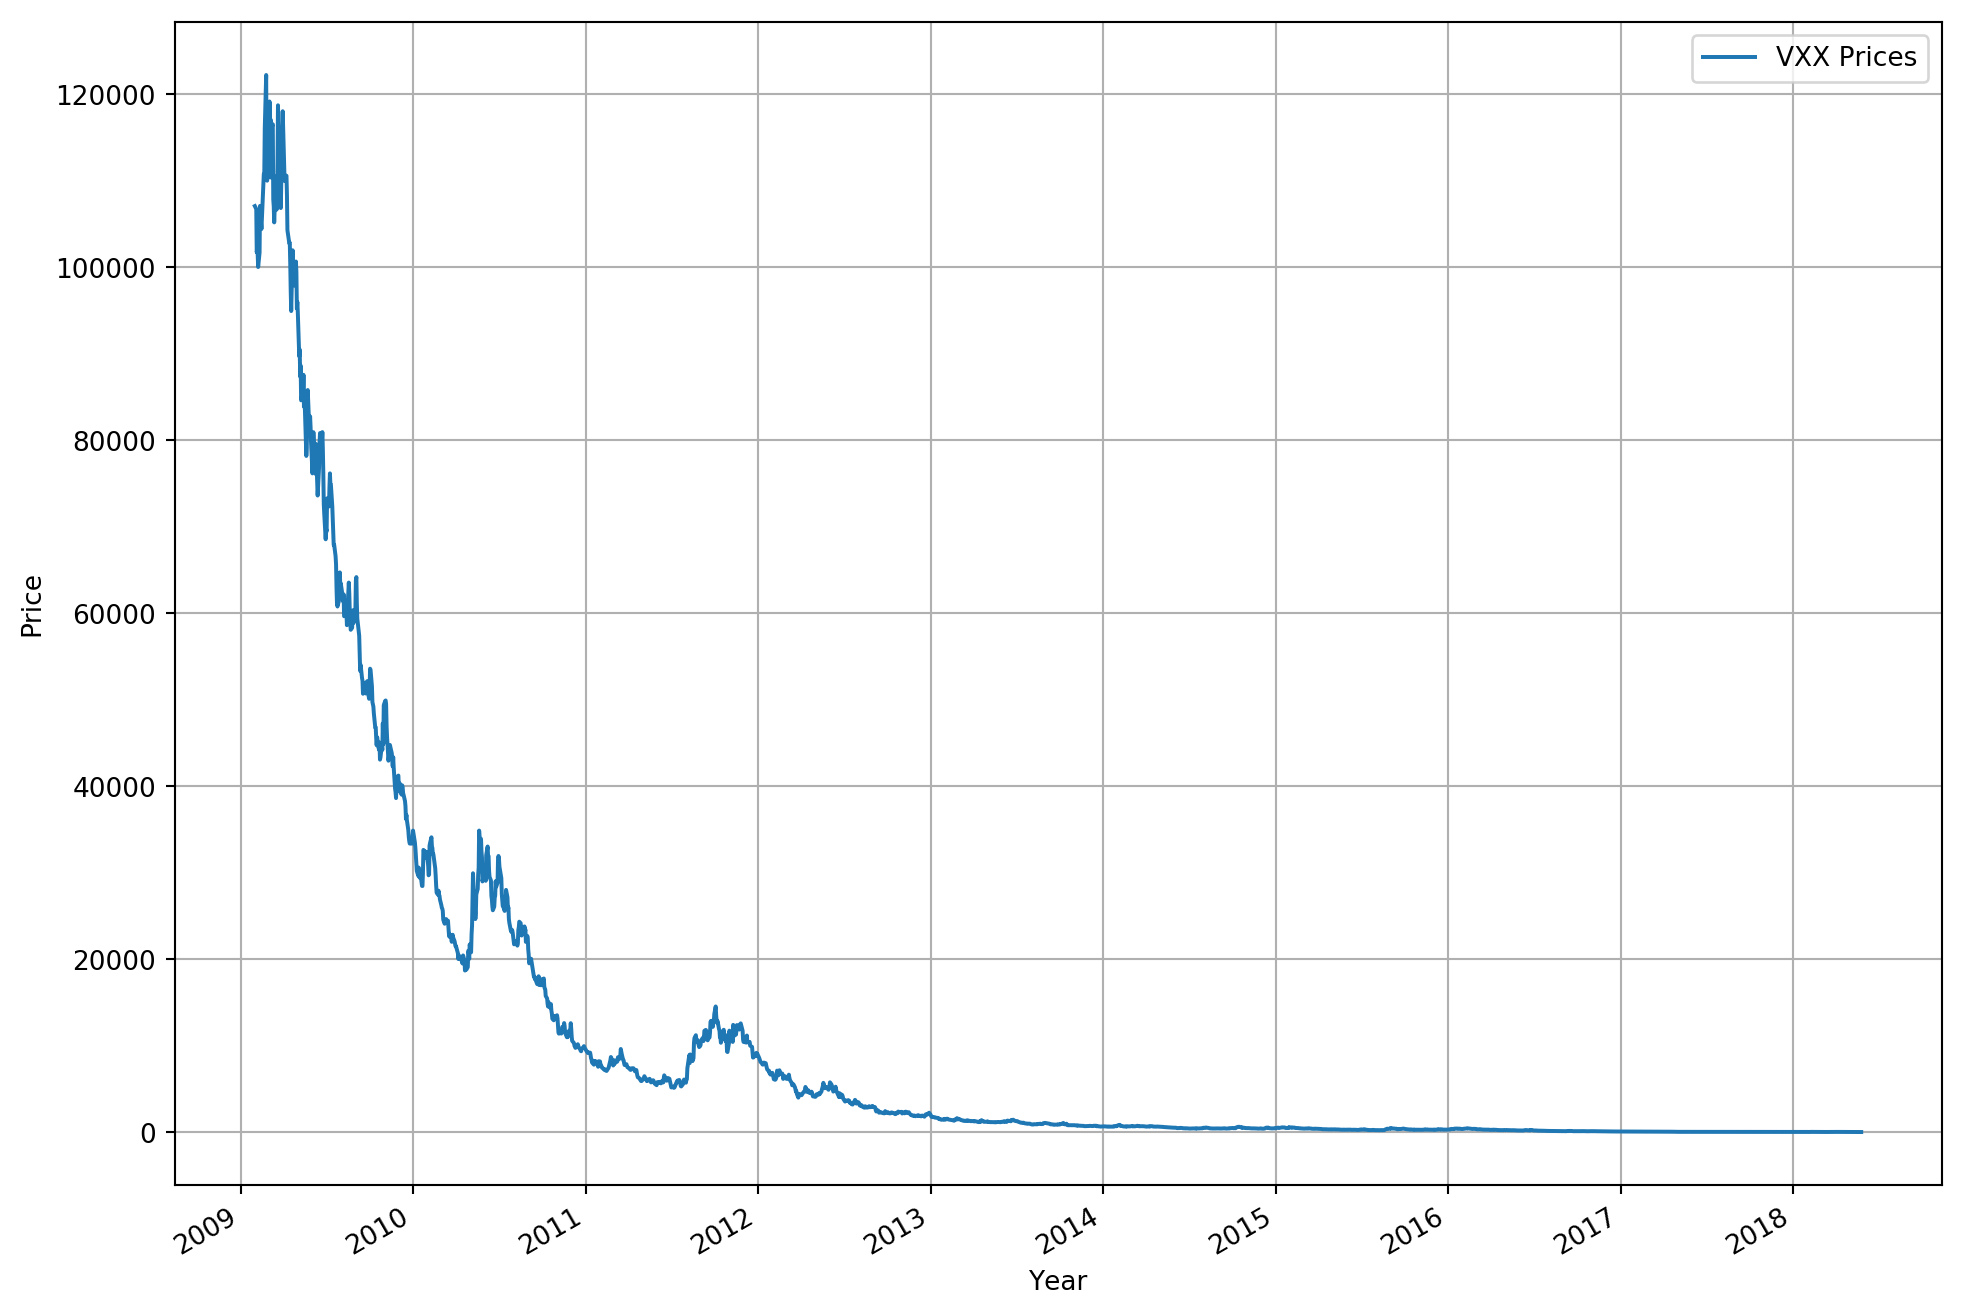

In [49]:
plt.figure(figsize=(12, 9), dpi=190)
vxx['Close'].plot()
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend(['VXX Prices']);

### Strategy Replication with GARCH(1,1) forecasts

Use a rolling window of 250 days prior to train the GARCH(1,1) model

- ISSUE: Figure out whether L1 optimal prediction is the one to use, if so how to incorporate and calculate?


In [50]:
from garch import garch_forecast

training_window_size = 250
test_data = sp500_returns['2014']

In [55]:
training_sample_1 = sp500_returns[:test_data.index[0]][::-1]
training_sample_1 = training_sample_1[:training_window_size]
garch_11 = arch_model(training_sample_1, vol='Garch', p=1,o=0,q=1,dist='Normal');
res = garch_11.fit();
C,A,B = res.params[1:]

Iteration:      1,   Func. Count:      6,   Neg. LLF: 263.47974282436815
Iteration:      2,   Func. Count:     15,   Neg. LLF: 263.37168481275614
Iteration:      3,   Func. Count:     22,   Neg. LLF: 263.17517145602034
Iteration:      4,   Func. Count:     30,   Neg. LLF: 263.10875863714534
Iteration:      5,   Func. Count:     37,   Neg. LLF: 263.05752615276856
Iteration:      6,   Func. Count:     44,   Neg. LLF: 263.0381955173306
Iteration:      7,   Func. Count:     50,   Neg. LLF: 263.0341513739442
Iteration:      8,   Func. Count:     56,   Neg. LLF: 263.0338486664255
Iteration:      9,   Func. Count:     62,   Neg. LLF: 263.0338448632416
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 263.03384486313064
            Iterations: 9
            Function evaluations: 62
            Gradient evaluations: 9


In [ ]:
# omega = R[0][0]
# alpha = R[0][1]
# beta = R[0][2]
# sigma2 = omega + alpha*(r[-1])**2 + beta*context.last_sigma

In [56]:
sigma2 = C + A*(training_sample_1[0]**2) + B*(np.var(training_sample_1))

In [69]:
RV = np.sqrt(sigma2*252)

In [74]:
RV

10.593156267737994

In [ ]:
train_window_size = 250 # only look at past year's values to estimate volatility
test_data = sp500_returns['2014']
vix_test_data = vix['Close'][test_data.index]


def garch_vol_positions(returns, train_window_size, test_data, vix_test_data):
    """generates a vector of positions corresponding to vol strategy using GARCH(1,1) forecasts"""

    for date in test_data.index:
        train_sample = returns[:date][::-1]
        train_sample = train_sample[:train_window_size]